<a href="https://colab.research.google.com/github/kidkmon/Sentiment-Analysis-TripAdvisor/blob/main/Analise_sentimentos_TripAdvisor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Configurações

In [120]:
from google.colab import drive # monta ambiente para salvar dados gerados no notebook
from datetime import date, datetime #biblioteca para tratamento de data
import pandas as pd # biblioteca para processamento dos dados
from pandas import json_normalize # realiza a normalização de campos do tipo json no dataframe
import numpy as np # biblioteca de algebra linear

import urllib.request # biblioteca que trabalha com requisições HTTP
import json # biblioteca para processamento de dados do tipo JSON

import seaborn as sns # biblioteca de plotagem de gráficos
import matplotlib.dates as mdates
import matplotlib.pyplot as plt # biblioteca para plotagem de gráficos
%matplotlib inline

from textblob import TextBlob # biblioteca para processamento de dados textuais
from sklearn.metrics import classification_report # biblioteca para calcular as principais métricas de classificação.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [121]:
#Instalação de pacotes
!python -m textblob.download_corpora
!pip install --upgrade geopandas

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to /root/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to /root/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.
Requirement already up-to-date: geopandas in /usr/local/lib/python3.6/dist-packages (0.8.1)


In [ ]:
# Versão das bibliotecas utilizadas
!python --version
print("Pandas", pd.__version__)
print("Numpy", np.__version__)


import geopandas #biblioteca para trabalhar com dados geospacial

Python 3.6.9
Pandas 1.1.4
Numpy 1.18.5


# Processamento de dados

In [122]:
def load_data(url, encoding="utf-8"):
  dat_file = urllib.request.urlopen(url)

  json_format_file = [json.loads(line) for line in dat_file]

  df = pd.DataFrame(json_format_file)
  
  return df

In [183]:
df = load_data(url="http://tiagodemelo.info/datasets/dataset-v2.dat")
df.head()

,title,reviewId,restaurantId,author,reviewBody,language,mobileDevice,userLocation,publicationDate,visitDate,ratingValue,itemReviewed
0,Jantar,692856288,2344932,larinhavercosa222,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,"São Carlos, SP",26/07/2019,07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ..."
1,Uma boa experiência.,229208487,3720906,Pano P,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,"Manaus, AM",16/09/2014,None,4,"{'name': 'Guacamole Natal', 'address': {'stree..."
2,Otimo self service,679002332,2248105,Magma100,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,"Goiânia, GO",04/06/2019,07/2018,4,"{'name': 'Chica Pitanga', 'address': {'streetA..."
3,O sorvete mais tradicional do estado,355671519,8168302,Yurie M,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,"Aracaju, SE",15/03/2016,01/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str..."
4,Melhor hamburger!,268741921,5395141,Debora_C85,O melhor hamburger que já comi! Excelente aten...,pt,False,"Rio de Janeiro, RJ",28/04/2015,04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'..."


## Limpeza dos dados

In [124]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column           Non-Null Count   Dtype 
---  ------           --------------   ----- 
 0   title            100000 non-null  object
 1   reviewId         100000 non-null  object
 2   restaurantId     99999 non-null   object
 3   author           99999 non-null   object
 4   reviewBody       99999 non-null   object
 5   language         100000 non-null  object
 6   mobileDevice     100000 non-null  object
 7   userLocation     100000 non-null  object
 8   publicationDate  100000 non-null  object
 9   visitDate        100000 non-null  object
 10  ratingValue      100000 non-null  object
 11  itemReviewed     100000 non-null  object
dtypes: object(12)
memory usage: 9.2+ MB


A partir das informações iniciais pode-se concluir que há dados faltantes na base de dados. Os campos que não possuem dados completos são: **restaurantId**, **author** e **reviewBody**.


## Remoção de colunas no dataset

Algumas colunas não irão exercer impacto durante a análise de dados, logo, optou-se por removê-las. Estas são: **reviewId**, **restaurantId**, **author** e **visitDate**.

In [125]:
columns = ["reviewId", "restaurantId", "author", "visitDate"]

df.drop(columns=columns, inplace=True)

Com a remoção de 3 colunas no conjunto de dados, nota-se que o **reviewBody** possui informações faltantes. Visto que esse campo é um dos mais importantes para a conclusão da análise de dados, optou-se por remover essa informação da base. 

In [126]:
df.dropna(inplace=True)

In [127]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99999 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   title            99999 non-null  object
 1   reviewBody       99999 non-null  object
 2   language         99999 non-null  object
 3   mobileDevice     99999 non-null  object
 4   userLocation     99999 non-null  object
 5   publicationDate  99999 non-null  object
 6   ratingValue      99999 non-null  object
 7   itemReviewed     99999 non-null  object
dtypes: object(8)
memory usage: 6.9+ MB


Agora todo o conjunto de dados possui 99.999 dados sobre revisões de restaurantes e 8 colunas.

## Criação de novas colunas para a análise


As informações das colunas **userLocation** e **itemReviewed** podem ser distribuídas em outras, facilitando, assim, a criação de novas visualizações de dados. 

A **userLocation** pode ser dividida em dados sobre a cidade e uma outra referente ao estado em que o usuário fez a revisão. 

In [184]:
## coluna userLocation

df["userLocation"]

0            São Carlos, SP
1                Manaus, AM
2               Goiânia, GO
3               Aracaju, SE
4        Rio de Janeiro, RJ
                ...        
99995      Porto Alegre, RS
99996         Cork, Irlanda
99997         São Paulo, SP
99998      Porto Alegre, RS
99999            Manaus, AM
Name: userLocation, Length: 100000, dtype: object

In [129]:
location = df["userLocation"].str.split(",", n = 1, expand = True) 

df["userCity"] = location[0]
df["userState"] = location[1]

df.drop(columns=["userLocation"], inplace=True)

df.head()

,title,reviewBody,language,mobileDevice,publicationDate,ratingValue,itemReviewed,userCity,userState
0,Jantar,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,26/07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ...",São Carlos,SP
1,Uma boa experiência.,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,16/09/2014,4,"{'name': 'Guacamole Natal', 'address': {'stree...",Manaus,AM
2,Otimo self service,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,04/06/2019,4,"{'name': 'Chica Pitanga', 'address': {'streetA...",Goiânia,GO
3,O sorvete mais tradicional do estado,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,15/03/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str...",Aracaju,SE
4,Melhor hamburger!,O melhor hamburger que já comi! Excelente aten...,pt,False,28/04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'...",Rio de Janeiro,RJ


In [130]:
## coluna itemReviewed

df["itemReviewed"]

0        {'name': 'Imperador dos Camarões', 'address': ...
1        {'name': 'Guacamole Natal', 'address': {'stree...
2        {'name': 'Chica Pitanga', 'address': {'streetA...
3        {'name': 'Sorvetes Vi Sabor', 'address': {'str...
4        {'name': 'Z Deli Sandwich Shop', 'address': {'...
                               ...                        
99995    {'name': 'Boteco Maestro', 'address': {'street...
99996    {'name': 'Casa do Marquês', 'address': {'stree...
99997    {'name': 'Rio Scenarium', 'address': {'streetA...
99998    {'name': 'Celeiro', 'address': {'streetAddress...
99999    {'name': 'Coco Bambu Manaus', 'address': {'str...
Name: itemReviewed, Length: 99999, dtype: object

A **itemReviewed** possui muitas informações interessantes e que podem contribuir para uma análise mais completa. Esses dados são: 

*   **name**: Nome do restaurante;
*   **address**: Endereço do restaurante;
*   **website**: Endereço do site do restaurante;
*   **email**: E-mail do restaurante;
*   **phoneNumber**: Telefone do restaurante;
*   **averageRating**: Média de avaliação do restaurante;


Os campos website, email e phoneNumber serão utilizados nessa análise para saber se os estabelecimentos que possuem essas informações possuem maior probabilidade de terem pontuações maiores.

In [131]:
item_reviewed = json_normalize(df["itemReviewed"])
item_reviewed.head()

,name,website,email,phoneNumber,averageRating,address.streetAddress,address.addressLocality,address.addressRegion,address.postalCode,address.country
0,Imperador dos Camarões,http://www.imperadordoscamaroes.com.br,contato@imperadordoscamaroes.com.br,+55 82 3231-4134,4.5,Avenida Doutor Antônio Gouveia,,Alagoas,57030-170,Brasil
1,Guacamole Natal,http://www.facebook.com/GuacamoleNatal,guacamolenatal@gmail.com,+55 84 3219-3646,4.5,Avenida Praia de Ponta Negra 9068 Ponta Negra,,Rio Grande do Norte,59092-100,Brasil
2,Chica Pitanga,http://www.chicapitanga.com.br,chicapitanga@chicapitanga.com.br,+55 81 3334-8260,4.5,Rua Petrolina 19,Recife,Pernambuco,51021-250,Brasil
3,Sorvetes Vi Sabor,None,None,None,4.0,Avenida Francisco Porto 59 Grageru,Aracaju,Sergipe,,Brasil
4,Z Deli Sandwich Shop,http://www.facebook.com/zdelisandwichshop/,None,551130830021,4.5,Rua Haddock Lobo 1386 Jardins,São Paulo,Estado de São Paulo,01414-002,Brasil


Processamento dos dados contidos no campo **itemReviewed**

In [132]:
df["hasEmail"] = item_reviewed["email"].apply(lambda value: 
                                                      "True" if value != "None" else "False")

df["hasEmail"].fillna("no")

0         True
1         True
2         True
3        False
4        False
         ...  
99995     True
99996    False
99997     True
99998     True
99999       no
Name: hasEmail, Length: 99999, dtype: object

In [133]:
df["hasPhone"] = item_reviewed["phoneNumber"].apply(lambda value: 
                                                      "True" if value != "None" else "False")

df["hasPhone"].fillna("no")

0         True
1         True
2         True
3        False
4         True
         ...  
99995     True
99996     True
99997     True
99998     True
99999       no
Name: hasPhone, Length: 99999, dtype: object

##Geração de dados para análise temporal

Gerando campos de ano, mês e dia a partir do campo publicationDate

In [ ]:
week_day = ('Segunda-feira', 'Terça-feira', 'Quarta-feira', 'Quinta-feira', 'Sexta-feira', 'Sábado', 'Domingo')
mes_ext = {'01': 'Jan', '02' : 'Fev', '03': 'Mar', '04': 'Abr', '05': 'Mai', '06': 'Jun', '07': 'Jul', '08': 'Ago', '09': 'Set', '10': 'Out', '11': 'Nov', '12': 'Dez'}

df["publication_year"] = [x[-4:] for x in df['publicationDate']]
df["publication_month"] = [x[3:5] for x in df['publicationDate']]
df["publication_month_ext"] = [mes_ext[x[3:5]] for x in df['publicationDate']]
df["publication_day"] = [x[:2] for x in df['publicationDate']]
df["publication_week"] = [week_day[datetime.strptime(x, "%d/%m/%Y").weekday()] for x in df['publicationDate']]

## Conjunto de dados após o processamento



In [ ]:
df.head()

,title,reviewBody,language,mobileDevice,publicationDate,ratingValue,itemReviewed,userCity,userState,hasEmail,hasPhone,publication_year,publication_month,publication_day,publication_week,publication_month_ext
0,Jantar,"Comida maravilhosa, lugar do verdadeiro chicle...",pt,True,26/07/2019,5,"{'name': 'Imperador dos Camarões', 'address': ...",São Carlos,SP,True,True,2019,07,26,Sexta-feira,Jul
1,Uma boa experiência.,"Comida boa, drinks legais e um ambiente bem ac...",pt,True,16/09/2014,4,"{'name': 'Guacamole Natal', 'address': {'stree...",Manaus,AM,True,True,2014,09,16,Terça-feira,Set
2,Otimo self service,"Excelente pra ir com a família! Ótima Comida, ...",pt,True,04/06/2019,4,"{'name': 'Chica Pitanga', 'address': {'streetA...",Goiânia,GO,True,True,2019,06,04,Terça-feira,Jun
3,O sorvete mais tradicional do estado,Tomo sorvete na Visabor faz mais de 30 anos. S...,pt,False,15/03/2016,5,"{'name': 'Sorvetes Vi Sabor', 'address': {'str...",Aracaju,SE,False,False,2016,03,15,Terça-feira,Mar
4,Melhor hamburger!,O melhor hamburger que já comi! Excelente aten...,pt,False,28/04/2015,5,"{'name': 'Z Deli Sandwich Shop', 'address': {'...",Rio de Janeiro,RJ,False,True,2015,04,28,Terça-feira,Abr


# Visão Geral dos Dados

In [212]:
language = df.groupby(["language"]).size().reset_index(name="count")

language.drop(language[language["language"] == ""].index, inplace=True)
language.drop(language[language["language"] == "None"].index, inplace=True)

language.head(10)

,language,count
2,en,789
3,es,17
4,it,1
5,iw,1
6,pt,99128
7,ru,1
8,sv,1


## Análise de Distribuição das Notas de Avaliações

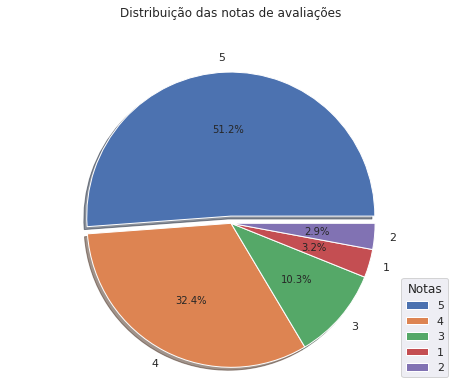

In [ ]:
labels = df['ratingValue'].unique()
rating_percent = df['ratingValue'].value_counts(normalize=True) * 100
explode = (0.05, 0, 0, 0, 0)

fig, ax = plt.subplots(figsize=(8,6))
ax.pie(rating_percent, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True)
ax.axis('equal')

plt.title('Distribuição das notas de avaliações', pad=40)
ax.legend(labels, loc='lower right', title='Notas')

plt.show()

A avaliação com nota 5 possui a maior frequência dentro do conjunto de dados, enquanto a com nota 2 são as menos frequentes. Dado o gráfico, é possível afirmar que os dados estão desbalanceados pois 51.2% deste conjunto de dados pertencem à avaliação com nota 5, enquanto as outras quatros notas juntas representam o restante dos dados.





## Análise de Distribuição das Avaliações por Diferentes Dispositivos

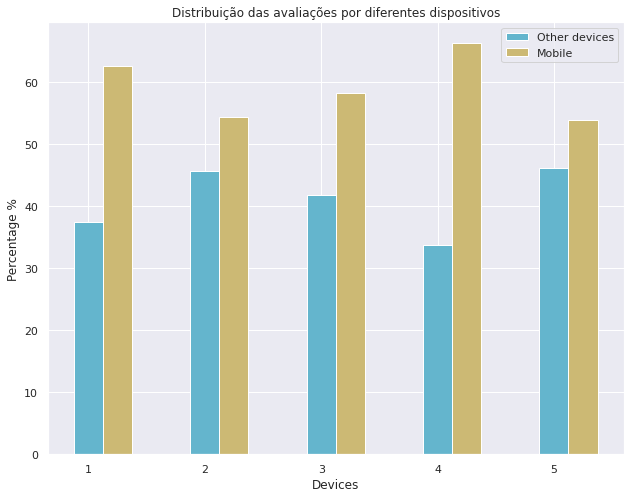

In [ ]:
def get_rating_value_devices():
  devices = []
  for i in range (1,6):
    devices.append(df[df['ratingValue'] == str(i)]['mobileDevice'].value_counts(normalize=True, sort=False) * 100)
  return devices

devices = get_rating_value_devices() 

fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])

X = np.arange(1,6)
ax.bar(X, [device[0] for device in devices], color='c', width = 0.25)
ax.bar(X+0.25, [device[1] for device in devices], color='y', width = 0.25)

plt.xlabel('Devices')
plt.ylabel('Percentage %')
plt.title('Distribuição das avaliações por diferentes dispositivos')
plt.legend(['Other devices', 'Mobile'])

plt.show()

Através do gráfico de barras acima, percebe-se que existe uma diferença de frequência entre dispositivos em relação as notas das avaliações. As notas de avaliações **1** e **2**, possuem as menores frequências de críticas realizadas em outros dispositivos e as maiores frequências realizadas em mobile, pode-se concluir que pessoas insatisfeitas com o restaurante, em sua maioria, possuem o interesse de realizar a crítica o quanto antes, dado isso a plataforma mais acessível seria a mobile.

## Análise Temporal de Interação

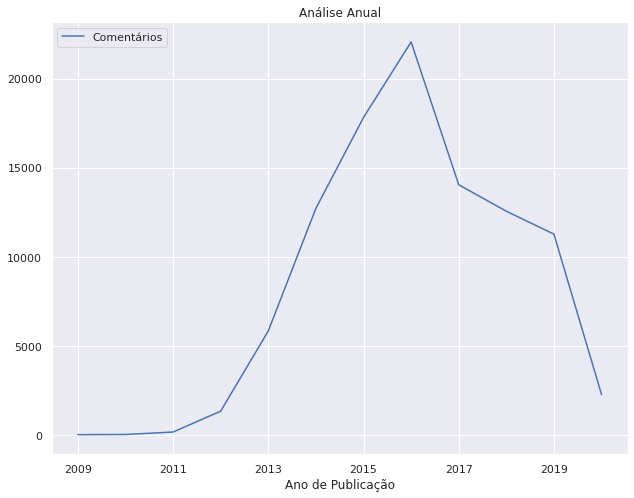

In [ ]:
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
df.groupby('publication_year')['reviewBody'].count().plot(kind='line', label ='Comentários' , color = 'b', ax=ax)
plt.xlabel('Ano de Publicação')
plt.legend(loc = 'upper left')
plt.title('Análise Anual')
plt.show()

O resultado desta análise mostra que o dataset contém amostras de dados do ano de 2009 à 2020, onde o maior número de amostras se concentra em 2016, havendo um crescimento exponancial da iteração de clientes a partir da metade de 2012, e que os dados de 2009 à 2011 são nulos.

## Análise de Interação por Localização

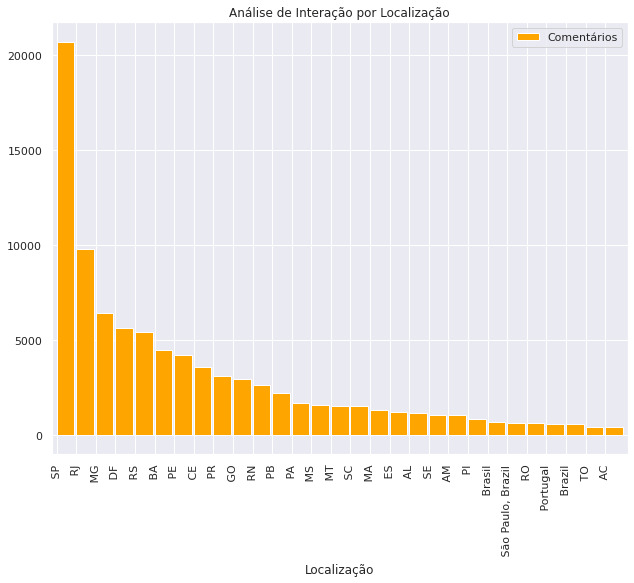

In [ ]:
#Gerando dados para análise - groupby
res = df[['userState','reviewBody']].groupby('userState').count()
a = res.sort_values(['reviewBody'], ascending=False)
a.rename({"reviewBody": "Comentários"}, axis=1, inplace=True)

#Construção do Gráfico
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
a[0:29].plot(kind='bar', color ='orange', orientation='horizontal', align='edge',width = 0.9, ax=ax)
plt.xlabel('Localização')
plt.legend(loc = 'upper right')
plt.title('Análise de Interação por Localização')
plt.show()


Através da análise dessa plotagem é visível que os brasileiros tem maior representatividade na interação, evidenciando que a maior parte dos comentários são nacionais, e poucos são estrangeiros. 
Dos 30 estados/países com maior representatividade, os estados nacionais aparecem com um índice de 96,6% e os estrangeiros com 3,3%.



## Média de Sentenças e Palavras por Comentários

In [ ]:
def mean_sentences_words():
  
  df['reviewBody_TB'] = [TextBlob(comment) for comment in df['reviewBody']]

  mean_sentences = np.mean([len(comment.sentences) for comment in df['reviewBody_TB']])
  mean_words = np.mean([len(comment.word_counts) for comment in df['reviewBody_TB']])

  return [mean_sentences, mean_words]

In [ ]:
mean_reviews = mean_sentences_words()

print("Média de sentenças por comentários: {:.2f}.\n" \
      "Média de palavras por comentários: {:.2f}.".format(mean_reviews[0],
                                                     mean_reviews[1]))

Média de sentenças por comentários: 3.63.
Média de palavras por comentários: 34.67.


# Etapa I

## Processamento de dados traduzidos para inglês

In [ ]:
df_en_comments = pd.read_csv('drive/Shareddrives/TripAdvisor/dataset_us.csv', encoding='utf-8',sep="³")

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
df_en_comments['comments_TB'] = [TextBlob(comment) for comment in df_en_comments['comment_us']]

## Cálculo da subjetividade e polaridade das sentenças

In [ ]:
df_sentence_type = []
df_sentence_polarity = []

for comment in df_en_comments['comments_TB']:
  df_sentence_type.append([sentence.sentiment.subjectivity for sentence in comment.sentences])
  df_sentence_polarity.append([sentence.sentiment.polarity for sentence in comment.sentences])

In [ ]:
df_sentiment_analysis = pd.DataFrame()

df_sentiment_analysis['type'] = [sentence_type for sentence in df_sentence_type
                                 for sentence_type in sentence]
df_sentiment_analysis['polarity'] = [sentence_polarity for sentence in df_sentence_polarity
                                 for sentence_polarity in sentence]

### Normalização dos cálculos de subjetividade e polaridade

In [ ]:
positive_min = 0.5
negative_min = -0.15

df_sentiment_analysis['type_normalized'] = [1 if sentence > positive_min
                                                 else -1 if sentence < negative_min
                                                 else 0 
                                                 for sentence in df_sentiment_analysis['type']]

df_sentiment_analysis['polarity_normalized'] = [1 if sentence > positive_min
                                                 else -1 if sentence < negative_min
                                                 else 0 
                                                 for sentence in df_sentiment_analysis['polarity']]

## Distribuição dos comentários do dataset

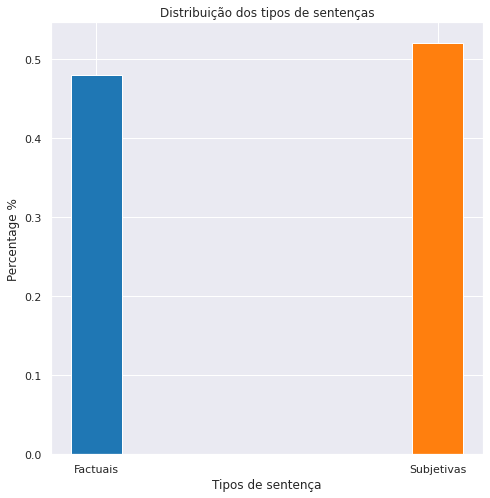

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])

X = ["Factuais", "Subjetivas"]
Y = df_sentiment_analysis['type_normalized'].value_counts(normalize=True, sort=False)
ax.bar(X, Y, color=['tab:blue','tab:orange'], width = 0.15)

plt.xlabel('Tipos de sentença')
plt.ylabel('Percentage %')
plt.title('Distribuição dos tipos de sentenças')

plt.show()

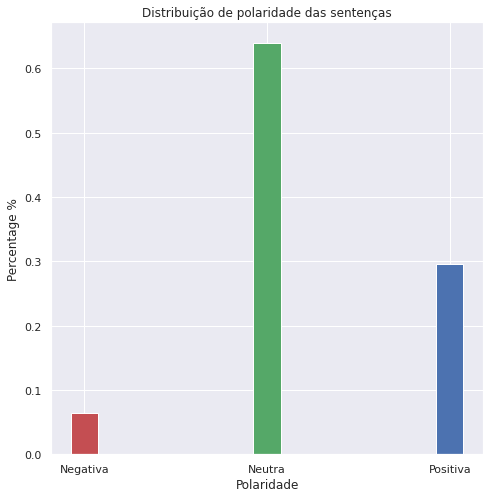

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])

X = ["Negativa", "Neutra", "Positiva"]
polarity = df_sentiment_analysis['polarity_normalized'].value_counts(normalize=True)
Y = [polarity[-1], polarity[0], polarity[1]]
ax.bar(X, Y, color=['r','g', 'b'], width = 0.15)

plt.xlabel('Polaridade')
plt.ylabel('Percentage %')
plt.title('Distribuição de polaridade das sentenças')

plt.show()

#Etapa II

***Análise do resultado do cálculo de subjetividade e polaridade das 200 sentenças utilizando o pacote TextBlob para tradução***

## Selecionar 200 senteças aleatórias da base de dados

In [ ]:
def generate_random_sentences_list():
  rand_sentences = []
  rand_index = np.random.randint(0, df['reviewBody_TB'].size)
  i = 0

  while i < 200:
    sentences = df['reviewBody_TB'][rand_index].sentences

    for sentence in sentences:
      rand_sentences.append(str(sentence))
    
    rand_index = np.random.randint(0, df['reviewBody_TB'].size)
    i += len(sentences)

  return rand_sentences

In [ ]:
rand_sentences = generate_random_sentences_list()

df_sentences = pd.DataFrame({'Sentences': rand_sentences,
                             'Type': [None] * len(rand_sentences),
                             'Polarity': [None] * len(rand_sentences)})

file_path = 'drive/Shareddrives/TripAdvisor/random_sentences_to_evaluate.csv'
df_sentences.to_csv(file_path, index=False)

## Análise de sentimentos das sentenças aleatórias

In [ ]:
file_path = "drive/Shareddrives/TripAdvisor/random_sentences.csv"
df_random_sentences = pd.read_csv(file_path)
df_random_sentences.head()

,Sentences,Type,Polarity
0,Uma ótima opção para quem leva uma vida saudáv...,1,1
1,Simplesmente amo!,1,1
2,Sempre peço o de carne com os diversos itens q...,0,0
3,Os sucos também são maravilhosos e adoçados co...,1,1
4,O pedido sai em menos de 5 minutos e o preço é...,1,0


### Tradução das sentenças para inglês

In [ ]:
df_random_sentences['sentences_TB'] = [TextBlob(comment).translate(to='us') for comment in df_random_sentences['Sentences']]

### Cálculo da polaridade

In [ ]:
df_random_sentences['polarity_TB'] = [sentence.sentiment.polarity for sentence in df_random_sentences['sentences_TB']]

### Normalização dos valores da coluna do cálculo da polaridade

In [ ]:
positive_min = 0.5
negative_min = -0.15

df_random_sentences['polarity_TB_normalized'] = [1 if sentence > positive_min
                                                 else -1 if sentence < negative_min
                                                 else 0 
                                                 for sentence in df_random_sentences['polarity_TB']]

### Métricas de desempenho

In [ ]:
target_names = ['Negativa', 'Neutra', 'Positiva']

print(classification_report(df_random_sentences['Polarity'], 
                      df_random_sentences['polarity_TB_normalized'],
                      target_names=target_names))

              precision    recall  f1-score   support

    Negativa       0.79      0.42      0.55        26
      Neutra       0.41      0.91      0.57        54
    Positiva       0.91      0.51      0.65       120

    accuracy                           0.60       200
   macro avg       0.70      0.61      0.59       200
weighted avg       0.76      0.60      0.62       200



## Questão 1

***Análise de Sentimentos - tradução com google trans***

###Processamento dos dados traduzidos

In [ ]:
df_trans_comments = pd.read_csv('drive/Shareddrives/TripAdvisor/dataset_trans.csv', encoding='utf-8', sep='³' )

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [ ]:
df_trans_comments['comments_TB'] = [TextBlob(comment) for comment in df_trans_comments['comment_us']]

###Cálculo da subjetividade e polaridade

In [ ]:
df_sentence_type2 = []
df_sentence_polarity2 = []

In [ ]:
for comment in df_trans_comments['comments_TB']:
  df_sentence_type2.append([sentence.sentiment.subjectivity for sentence in comment.sentences])
  df_sentence_polarity2.append([sentence.sentiment.polarity for sentence in comment.sentences])

In [ ]:
df_trans_sentiment_analysis = pd.DataFrame()

df_trans_sentiment_analysis['type'] = [sentence_type for sentence in df_sentence_type2
                                 for sentence_type in sentence]
df_trans_sentiment_analysis['polarity'] = [sentence_polarity for sentence in df_sentence_polarity2
                                 for sentence_polarity in sentence]

###Normalização dos cálculos de subjetividade e polaridade

In [ ]:
positive_min = 0.5
negative_min = -0.15

df_trans_sentiment_analysis['type_normalized'] = [1 if sentence > positive_min
                                                 else -1 if sentence < negative_min
                                                 else 0 
                                                 for sentence in df_trans_sentiment_analysis['type']]

df_trans_sentiment_analysis['polarity_normalized'] = [1 if sentence > positive_min
                                                 else -1 if sentence < negative_min
                                                 else 0 
                                                 for sentence in df_trans_sentiment_analysis['polarity']]

###Distribuição dos comentários do dataset

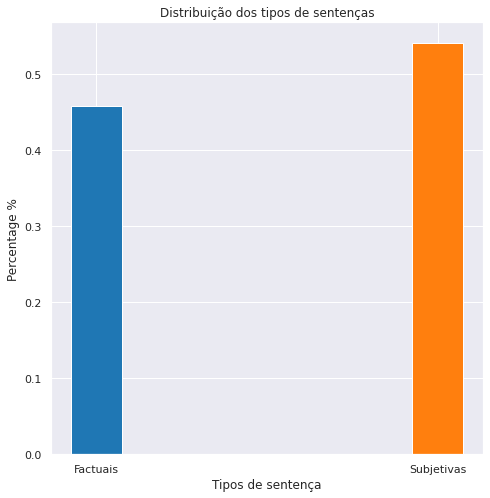

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])

X = ["Factuais", "Subjetivas"]
Y = df_trans_sentiment_analysis['type_normalized'].value_counts(normalize=True, sort=False)
ax.bar(X, Y, color=['tab:blue','tab:orange'], width = 0.15)

plt.xlabel('Tipos de sentença')
plt.ylabel('Percentage %')
plt.title('Distribuição dos tipos de sentenças')

plt.show()

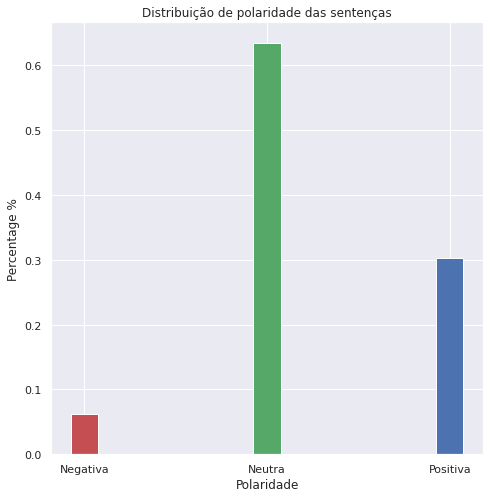

In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_axes([0,0,1,1])

X = ["Negativa", "Neutra", "Positiva"]
polarity = df_trans_sentiment_analysis['polarity_normalized'].value_counts(normalize=True)
Y = [polarity[-1], polarity[0], polarity[1]]
ax.bar(X, Y, color=['r','g', 'b'], width = 0.15)

plt.xlabel('Polaridade')
plt.ylabel('Percentage %')
plt.title('Distribuição de polaridade das sentenças')

plt.show()

#Visão Temporal

**Dia da Semana com maior ocorrência de postagens**

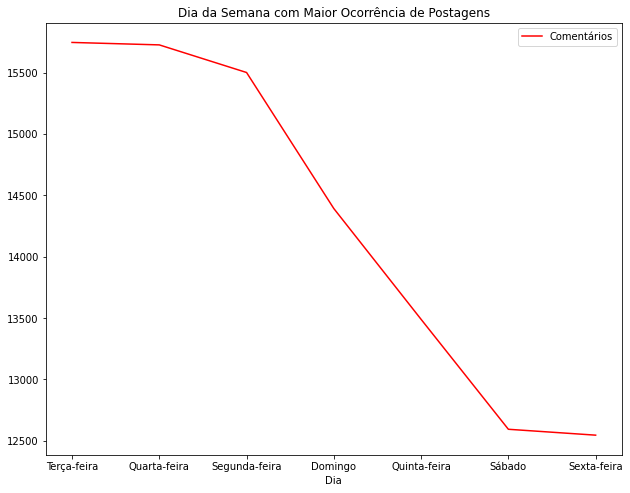

In [ ]:
#Gerando dados para análise - groupby
res = df[['publication_week','reviewBody']].groupby('publication_week').count()

a = res.sort_values(['reviewBody'], ascending=False)
a.rename({"reviewBody": "Comentários"}, axis=1, inplace=True)

#Construção do Gráfico
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
a[0:29].plot(kind='line', color ='r', ax=ax)
plt.xlabel('Dia')
plt.legend(loc = 'upper right')
plt.title('Dia da Semana com Maior Ocorrência de Postagens')
plt.show()

**Análise do ano com maior número de interação (2016)**

In [ ]:
df_date= df[df.publication_year == "2016"]
df_date.head()

In [ ]:

#Gerando dados para análise - groupby
res = df_date[['publication_month','reviewBody']].groupby('publication_month', sort=True).count()
a = res.sort_values(['publication_month'], ascending=True)
a.rename({"reviewBody": "Comentários"}, axis=1, inplace=True)

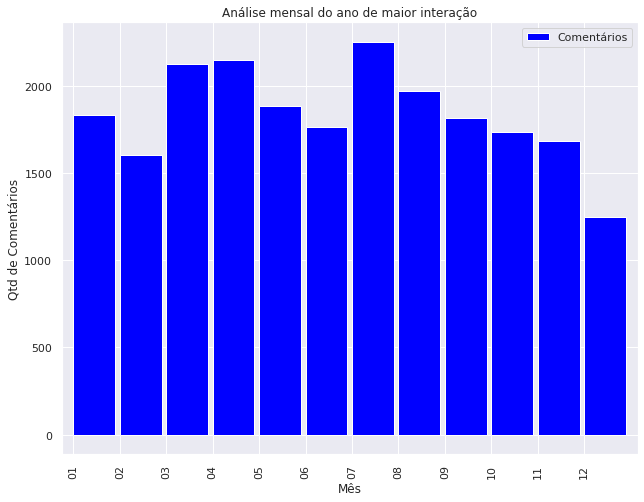

In [ ]:

#Construção do Gráfico
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
a[0:29].plot(kind='bar', color ='blue', orientation='horizontal', align='edge',width = 0.9, ax=ax)
plt.xlabel('Mês')
plt.ylabel('Qtd de Comentários')
plt.legend(loc = 'upper right')
plt.title('Análise mensal do ano de maior interação')
plt.show()

No ano de 2016, o mês de julho foi o mês que teve maior número de ocorrências com 2251 comentários

**Análise do mês com maior ocorrência de interação (2009 - 2020)**

In [ ]:
#Gerando dados para análise - groupby
res = df[['publication_month','reviewBody']].groupby('publication_month', sort=True).count()
a = res.sort_values(['publication_month'], ascending=True)
a.rename({"reviewBody": "Comentários"}, axis=1, inplace=True)


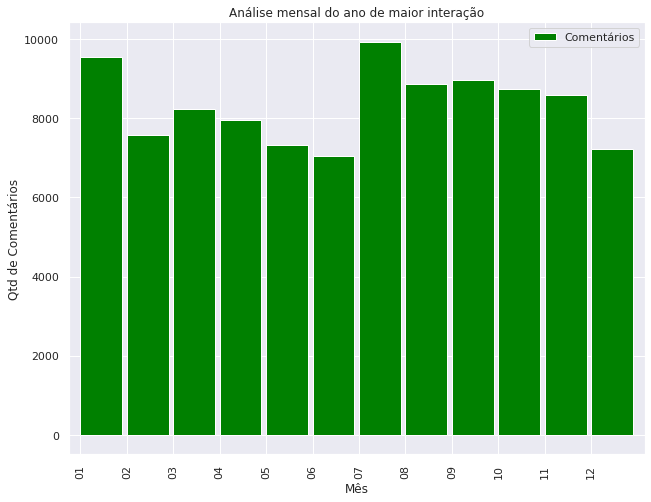

In [ ]:
#Construção do Gráfico
fig = plt.figure(figsize=(8,6))
ax = fig.add_axes([0,0,1,1])
a[0:29].plot(kind='bar', color= 'green', orientation='horizontal', align='edge',width = 0.9, ax=ax)
plt.xlabel('Mês')
plt.ylabel('Qtd de Comentários')
plt.legend(loc = 'upper right')
plt.title('Análise mensal do ano de maior interação')
plt.show()

Julho é o mês onde ocorre o maior número de ocorrências de todos os anos.

#Visão Geográfica

Para a realização desta etapa foi criado um conjunto de dados à parte após a geração de dados de longitude e latitude, através da biblioteca geocode.

In [167]:
import geopandas

df_geo = pd.read_csv("data/arquivo.txt", names=["country", "region", "city", "latitude", "longitude"])
df_geo.head()

,country,region,city,latitude,longitude
0,Argentina,None,Maipú,-32.9584934,-68.7895478
1,Brasil,Região Sudeste,Presidente Venceslau,-21.8744122,-51.8443312
2,España,None,València,39.4699075,-0.3762881
3,United States of America,None,Denville,40.8923212,-74.47737750000002
4,United States of America,None,Princeton,40.3572976,-74.6672226


**Análise de usuários que mais comentam na plataforma (Por Região)**

In [168]:
#Gerando dados para análise - groupby
region = df_geo[df_geo["country"] == "Brasil"]
region_gb = region.groupby(["region"]).size().reset_index(name="count")
region_gb.head()

,region,count
0,Região Centro-Oeste,230
1,Região Nordeste,491
2,Região Norte,160
3,Região Sudeste,953
4,Região Sul,426


No handles with labels found to put in legend.


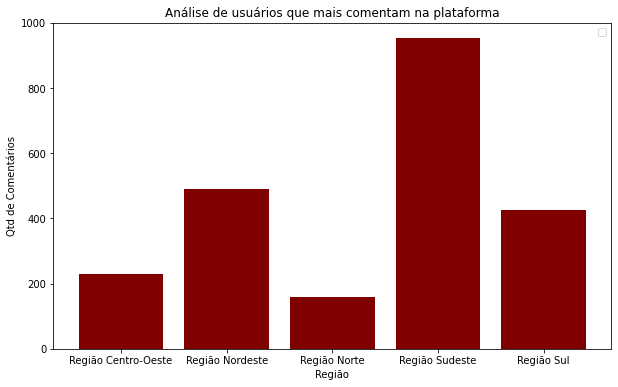

In [172]:
#Construção do Gráfico
fig = plt.figure(figsize=(10,6))
plt.bar(region_gb["region"], region_gb["count"], color ='maroon')

region_gb.plot(kind='bar', color= 'green', orientation='horizontal', align='edge',width = 0.9, ax=ax)

plt.xlabel('Região')
plt.ylabel('Qtd de Comentários')
plt.legend(loc = 'upper right')
plt.title('Análise de usuários que mais comentam na plataforma')
plt.show()

**Análise de usuários que mais comentam na plataforma (Por Cidade e Região)**

In [179]:
#Gerando dados para análise - groupby
region_gb = region.groupby(["city", "region"]).size().reset_index(name="count").sort_values(by="count", ascending=False)
region_gb.head(10)

,city,region,count
788,São Paulo,Região Sudeste,65
648,Rio de Janeiro,Região Sudeste,49
591,Porto Alegre,Região Sul,31
663,Salvador,Região Nordeste,29
620,Recife,Região Nordeste,26
580,Plano Piloto,Região Centro-Oeste,23
81,Belo Horizonte,Região Sudeste,23
778,São Luís,Região Nordeste,19
404,Manaus,Região Norte,19
398,Maceió,Região Nordeste,18


**Análise de valor de revisão por região**

In [190]:
# Gerando dados para análise - groupby
user_location = df.groupby(["userLocation", "ratingValue"]).size().reset_index(name="count").sort_values(by="count", ascending=True)

user_location.drop(user_location[user_location["userLocation"] == "None"].index, inplace=True)
user_location.drop(user_location[user_location["userLocation"].str.len() == 1].index, inplace=True)
user_location.drop(user_location[user_location["userLocation"].str.isdigit()].index, inplace=True)


region_gb = region.groupby(["region"]).size().reset_index(name="count").sort_values(by="count", ascending=False)

region_gb["ratingValues"] = ["5", "4", "3", "2", "1"]

region_gb.head()

,region,count,ratingValues
3,Região Sudeste,953,5
1,Região Nordeste,491,4
4,Região Sul,426,3
0,Região Centro-Oeste,230,2
2,Região Norte,160,1


**Regiões que mais dão nota máxima ao restaurante**

No handles with labels found to put in legend.


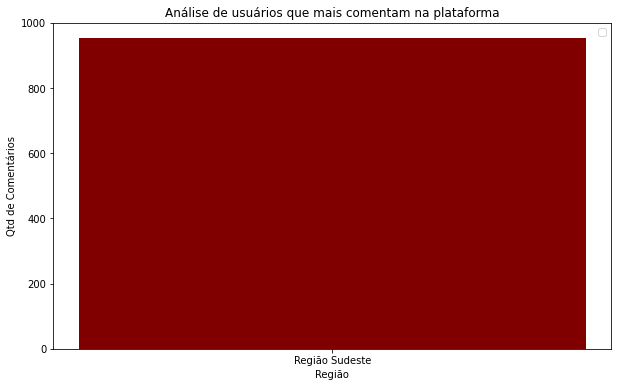

In [192]:
rating_region = region_gb[ region_gb["ratingValues"] == "5"]

#Construção do Gráfico
fig = plt.figure(figsize=(10,6))
plt.bar(rating_region["region"], rating_region["count"], color ='maroon')

region_gb.plot(kind='bar', color= 'green', orientation='horizontal', align='edge',width = 0.9, ax=ax)

plt.xlabel('Região')
plt.ylabel('Qtd de Comentários')
plt.legend(loc = 'upper right')
plt.title('Análise de usuários que mais comentam na plataforma')
plt.show()


**Regiões que mais dão nota mínima ao restaurante**

No handles with labels found to put in legend.


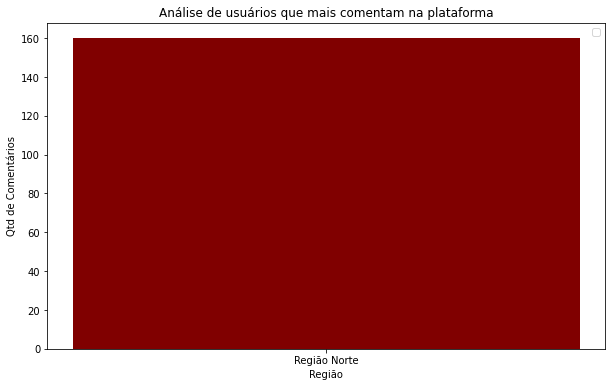

In [193]:
rating_region = region_gb[ region_gb["ratingValues"] == "1"]


#Construção do Gráfico
fig = plt.figure(figsize=(10,6))
plt.bar(rating_region["region"], rating_region["count"], color ='maroon')

region_gb.plot(kind='bar', color= 'green', orientation='horizontal', align='edge',width = 0.9, ax=ax)

plt.xlabel('Região')
plt.ylabel('Qtd de Comentários')
plt.legend(loc = 'upper right')
plt.title('Análise de usuários que mais comentam na plataforma')
plt.show()

**Visualização da distribuição da localização dos usuário em formato de mapa**

In [139]:
new_df_geo = df_geo[0:10]

In [141]:
gdf = geopandas.GeoDataFrame(
    new_df_geo, geometry=geopandas.points_from_xy(new_df_geo.longitude, new_df_geo.latitude))

gdf.head()

,city,state,latitude,longitude,geometry
Argentina,None,Maipú,-32.9584934,-68.7895478,POINT (-68.78955 -32.95849)
Brasil,Região Sudeste,Presidente Venceslau,-21.8744122,-51.8443312,POINT (-51.84433 -21.87441)
España,None,València,39.4699075,-0.3762881,POINT (-0.37629 39.46991)
United States of America,None,Denville,40.8923212,-74.47737750000002,POINT (-74.47738 40.89232)
United States of America,None,Princeton,40.3572976,-74.6672226,POINT (-74.66722 40.35730)


In [146]:
world = geopandas.read_file(
    geopandas.datasets.get_path('naturalearth_lowres')
)

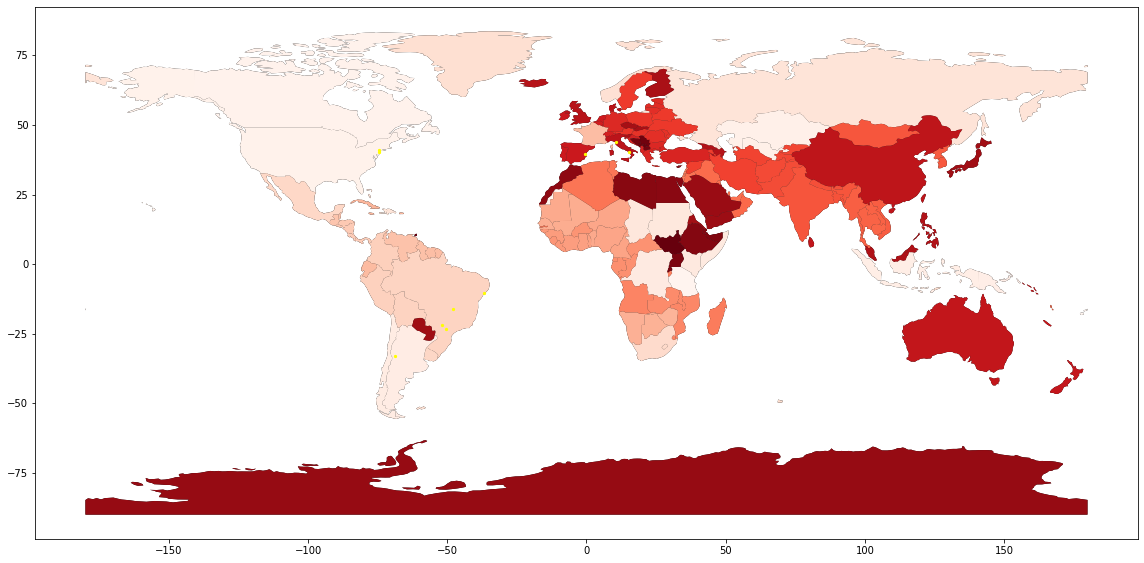

In [148]:
fig, ax = plt.subplots(1, figsize =(16, 8)) 

world.plot(ax = ax, color = 'black') 
world.plot(ax = ax, cmap = 'Reds')

gdf.plot(markersize=5, color='yellow', ax = ax)
plt.tight_layout()
plt.show()